# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

Resources Used:
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Variational AutoEncoder](https://keras.io/examples/generative/vae/)
- [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/)

In [1]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator

In [34]:
image_size = 128
channels = 3

# Autoencoder.
dropout = 0.1
autoencoder_batch_size = 512
diffusion_batch_size = 2048
autoencoder_widths = [16, 8, 8, 8, 8]
autoencoder_depth = 10
latent_size = 4

# Diffusion.
min_signal_rate = 0.02
max_signal_rate = 0.95
embedding_dims = 32
embedding_max_frequency = 1000.0
diffusion_widths = [32, 64, 96]
diffusion_block_depth = 2

In [8]:
def preprocessing_function(image):
    image = image.astype(float) / 255
    return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)
dogs = idg.flow_from_directory(
    '../stanford_dogs/images/Images/', 
    target_size = (image_size, image_size), 
    batch_size = autoencoder_batch_size,
    color_mode = 'rgb',
    classes = ['']
)

Found 20580 images belonging to 1 classes.


## Variational Autoencoder

In [9]:
def EncoderBlock(widths):
    def apply(x):
        for i in range(len(widths)):
            x = layers.Conv2D(widths[i], (3, 3), activation='relu', padding='same')(x)
            x = layers.MaxPooling2D((2, 2), padding='same')(x)
        return x
    
    return apply

def DecoderBlock(widths):
    def apply(x):
        for i in range(len(widths)):
            x = layers.Conv2D(widths[i], (3, 3), activation='relu', padding='same')(x)
            x = layers.UpSampling2D((2, 2))(x)
            
        x = layers.Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)
        return x
    
    return apply

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(z_mean.shape[1], z_mean.shape[2], channels))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
class VAE(keras.Model):
    def __init__(self, widths, encoder=None, decoder=None):
        super().__init__()
        self.encoder_widths = widths
        self.decoder_widths = list(reversed(widths))
        
        if encoder != None:
            self.encoder = encoder
        else:
            self.encoder = self.create_encoder()
            
        if decoder != None:
            self.decoder = decoder
        else:
            self.decoder = self.create_decoder()
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def create_encoder(self):
        input_image = layers.Input(shape=(image_size, image_size, channels))
        x = EncoderBlock(self.encoder_widths)(input_image)
        z_mean = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z_log_var = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(input_image, [z_mean, z_log_var, z])
    
    def create_decoder(self):
        input_latent = layers.Input(shape=(latent_size, latent_size, channels))
        decoded = DecoderBlock(self.decoder_widths)(input_latent)
        return keras.Model(input_latent, decoded)
    
    def train_step(self, data):
        data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def encode(self, data):
        _, _, z = self.encoder(data)
        return z
    
    def decode(self, data):
        x = self.decoder(data)
        return x

In [ ]:
vae = VAE(autoencoder_widths)
vae.compile(optimizer='adam')
vae.fit(dogs, epochs=1000)

In [24]:
vae.encoder.save('data/encoder3')
vae.decoder.save('data/decoder3')

INFO:tensorflow:Assets written to: data/encoder3\assets


INFO:tensorflow:Assets written to: data/encoder3\assets


INFO:tensorflow:Assets written to: data/decoder3\assets


INFO:tensorflow:Assets written to: data/decoder3\assets


In [25]:
dogs.reset()
encoded_images = vae.encode(dogs.next()[0])

for i in range(dogs.__len__()):
    next_encoded = vae.encode(dogs.next()[0])
    encoded_images = tf.concat([encoded_images, next_encoded], axis=0)

encoded_images.shape

TensorShape([21092, 4, 4, 3])

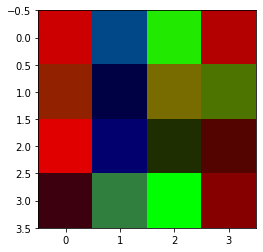

In [26]:
plt.imshow(encoded_images[0].numpy().reshape(latent_size, latent_size, channels))

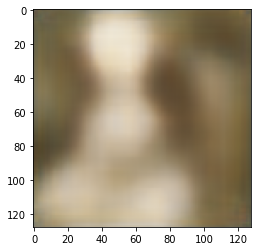

In [27]:
decoded_images = vae.decode(encoded_images[0 : 2])
plt.imshow(decoded_images[0].numpy().reshape(image_size, image_size, channels))

## Denoising U-Net

In [28]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(tf.linspace(tf.math.log(embedding_min_frequency),
                         tf.math.log(embedding_max_frequency),
                         embedding_dims // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
    return embeddings

def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [37]:
class DiffusionModel(keras.Model):
    def __init__(self, input_size, block_depth, widths):
        super().__init__()
        
        self.normalizer = layers.Normalization()
        self.model = self.create_model(input_size, widths, block_depth)
        self.input_size = input_size
    
    def create_model(self, input_size, widths, block_depth):
        noisy_input = keras.Input(shape=(input_size, input_size, channels))
        noise_variances = keras.Input(shape=(1, 1, 1))
        
        e = layers.Lambda(sinusoidal_embedding)(noise_variances)
        e = layers.UpSampling2D(size=input_size, interpolation='nearest')(e)
        
        x = layers.Conv2D(widths[0], kernel_size=1)(noisy_input)
        x = layers.Concatenate()([x, e])
        
        skips = []
        for width in widths[:-1]:
            x = DownBlock(width, block_depth)([x, skips])
            
        for _ in range(block_depth):
            x = ResidualBlock(widths[-1])(x)
        
        for width in reversed(widths[:-1]):
            x = UpBlock(width, block_depth)([x, skips])
            
        x = layers.Conv2D(channels, kernel_size=1, kernel_initializer='zeros')(x)
        
        return keras.Model([noisy_input, noise_variances], x)
    
    def compile(self, **kwargs):
        super().compile(**kwargs)
        
        self.noise_loss_tracker = keras.metrics.Mean(name='n_loss')
        self.image_loss_tracker = keras.metrics.Mean(name='i_loss')
    
    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]
    
    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates
    
    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        pred_noises = self.model([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        return pred_noises, pred_images
    
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]    
        step_size = 1.0 / diffusion_steps
        
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images
            
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            
        return pred_images
    
    def generate(self, num_images, diffusion_steps):
        initial_noise = tf.random.normal(shape=(num_images, self.input_size, self.input_size, channels))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        return generated_images
    
    def train_step(self, images):
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(diffusion_batch_size, self.input_size, self.input_size, channels))
        
        diffusion_times = tf.random.uniform(
            shape=(diffusion_batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        
        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )
            
            noise_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_absolute_error(noises, pred_noises), axis=(1, 2)
                )
            )
            
            image_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_absolute_error(images, pred_images), axis=(1, 2)
                )
            )
            
        grads = tape.gradient(noise_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)
            
        return {m.name: m.result() for m in self.metrics}

In [38]:
end_index = int(encoded_images.shape[0] / diffusion_batch_size) * diffusion_batch_size
encoded_images = encoded_images[:end_index]

In [39]:
model = DiffusionModel(latent_size, diffusion_block_depth, diffusion_widths)
model.compile(optimizer='adam')

In [40]:
model.fit(encoded_images, epochs=100, batch_size=diffusion_batch_size)

Epoch 1/100
10/10 [==============================] - 2s 21ms/step - n_loss: 12.0184 - i_loss: 37.0079
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - n_loss: 8.4764 - i_loss: 22.6453
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - n_loss: 6.3585 - i_loss: 14.3425
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - n_loss: 5.5830 - i_loss: 10.8227
Epoch 5/100
10/10 [==============================] - 0s 21ms/step - n_loss: 5.0759 - i_loss: 8.8356
Epoch 6/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.7866 - i_loss: 7.6912
Epoch 7/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.6850 - i_loss: 7.0219
Epoch 8/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.6040 - i_loss: 6.6972
Epoch 9/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.5742 - i_loss: 6.4782
Epoch 10/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.5371 - i_loss: 6

10/10 [==============================] - 0s 21ms/step - n_loss: 4.3612 - i_loss: 5.7478
Epoch 83/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.3724 - i_loss: 5.7401
Epoch 84/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.3408 - i_loss: 5.7431
Epoch 85/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.3575 - i_loss: 5.7371
Epoch 86/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.3881 - i_loss: 5.7387
Epoch 87/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.4057 - i_loss: 5.7541
Epoch 88/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.3548 - i_loss: 5.7538
Epoch 89/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.3577 - i_loss: 5.7524
Epoch 90/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.3575 - i_loss: 5.7625
Epoch 91/100
10/10 [==============================] - 0s 21ms/step - n_loss: 4.3692 - i_loss: 5.7634
Epo

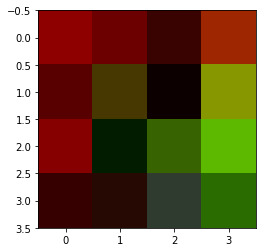

In [41]:
generated_latents = model.generate(8, 20)
plt.imshow(generated_latents[2].numpy().reshape(latent_size, latent_size, channels))

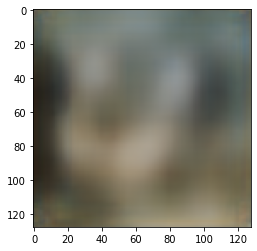

In [48]:
generated_latents = model.generate(2, 20)
generated_images = vae.decode(generated_latents)
plt.imshow(generated_images[0].numpy().reshape(image_size, image_size, channels), cmap='gray')

In [310]:
unet.save('../latent_diffusion_unet3')

INFO:tensorflow:Assets written to: ../latent_diffusion_unet3\assets


INFO:tensorflow:Assets written to: ../latent_diffusion_unet3\assets
